## Random GRNs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

plt.rcParams.update({"font.size": 16})

import helper

/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:164: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/gpfs1/home/c/p/cpetak/CA_GRN2/helper.py:185: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


### Random GRNs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


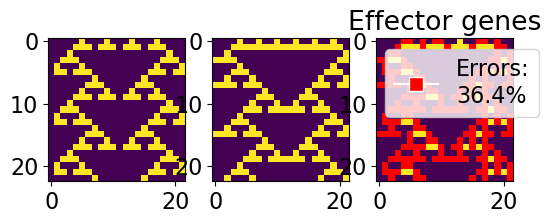

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


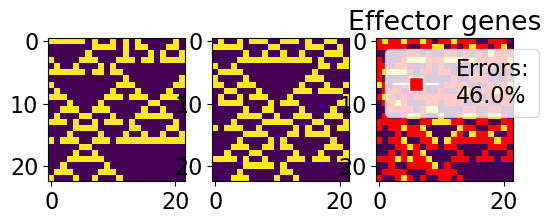

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


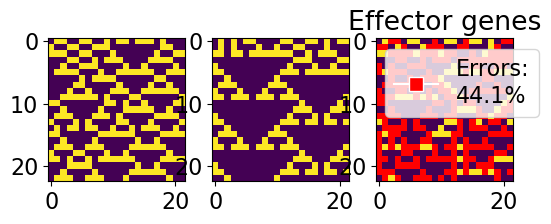

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


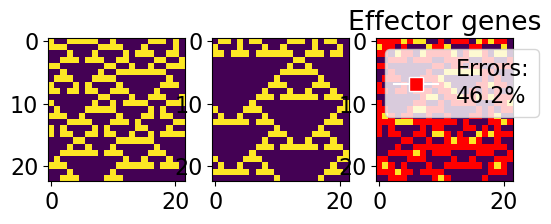

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


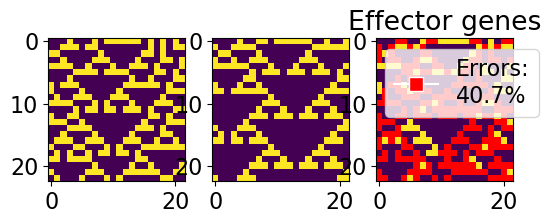

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


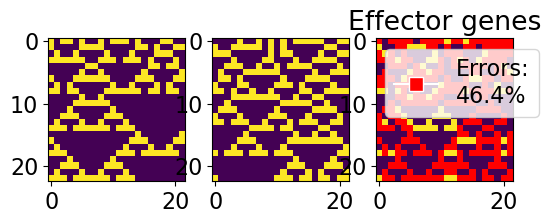

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22


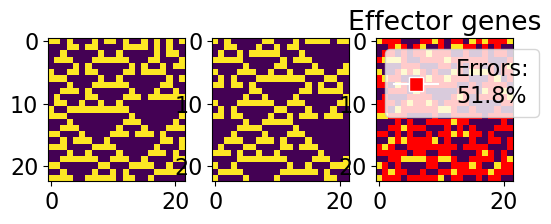

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


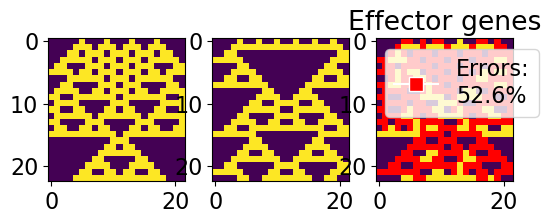

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


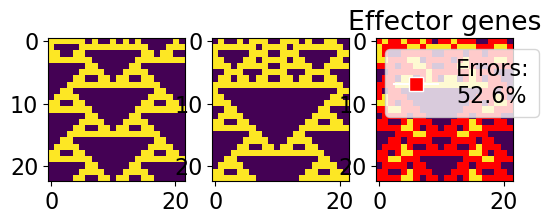

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


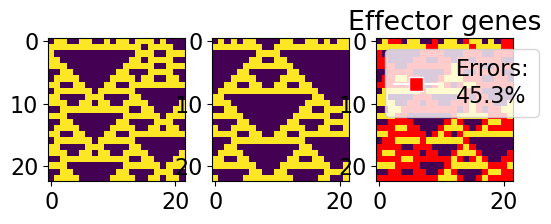

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


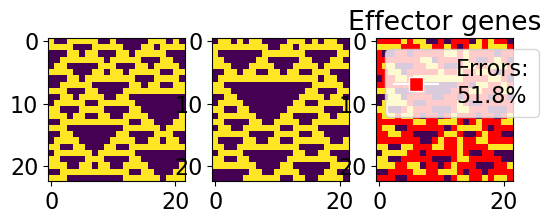

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


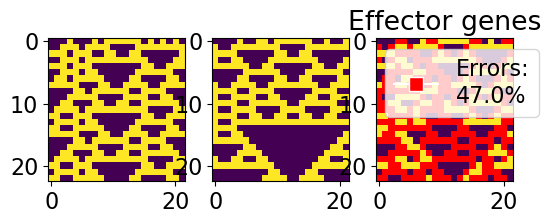

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


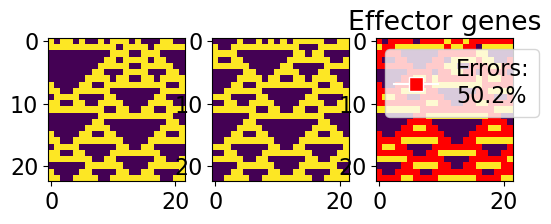

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


126


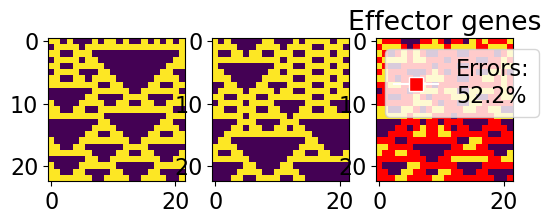

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


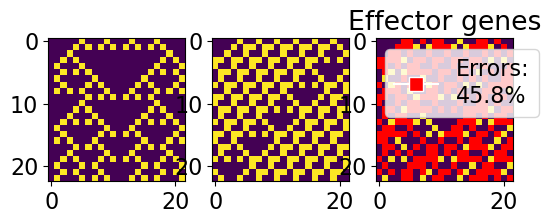

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


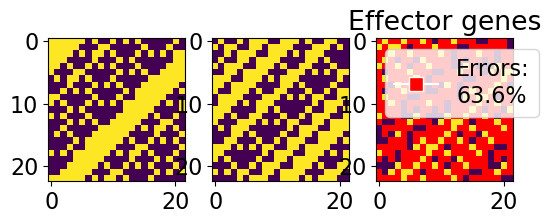

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


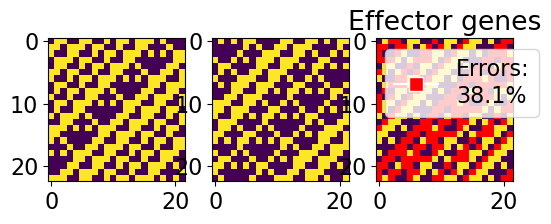

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


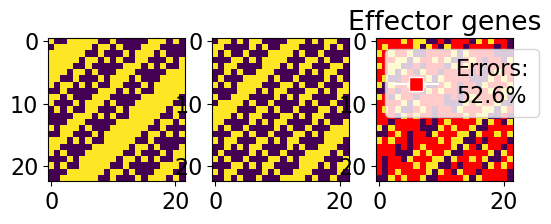

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


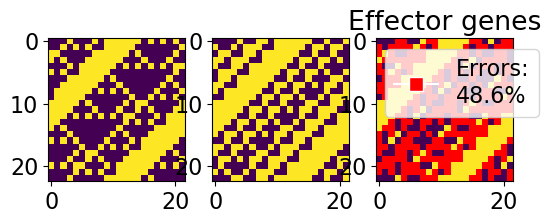

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


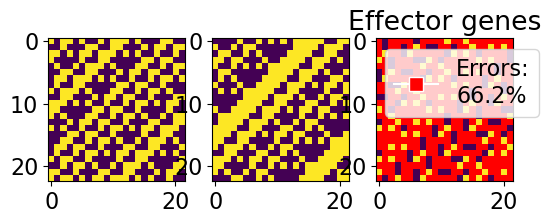

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


154


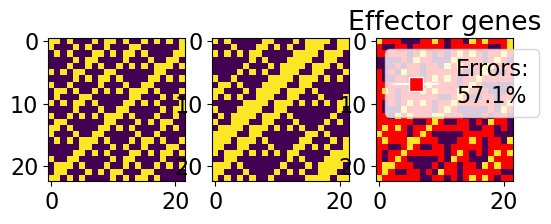

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


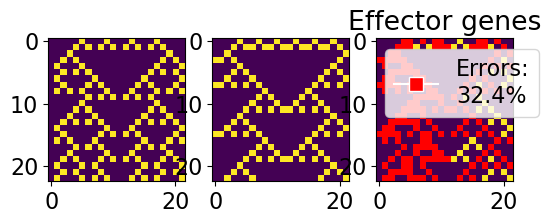

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


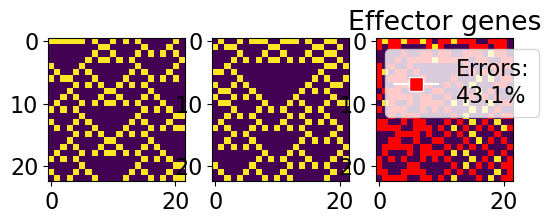

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


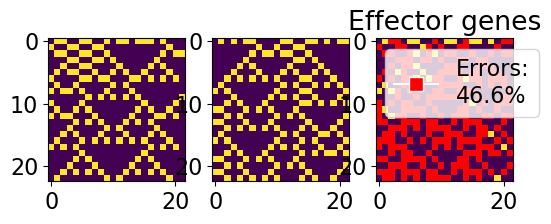

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


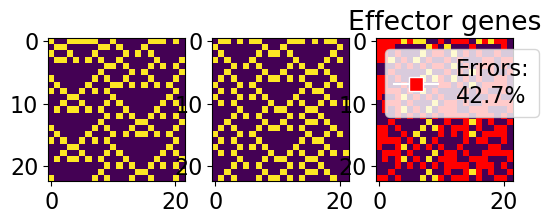

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


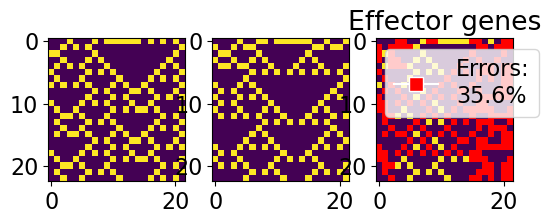

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18


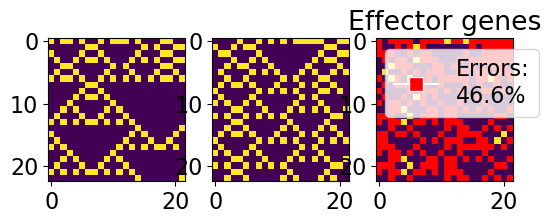

18


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


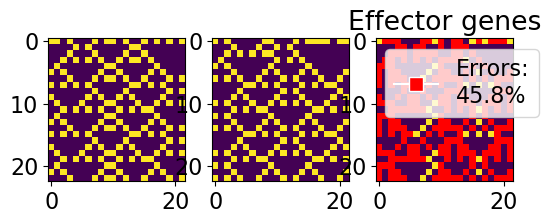

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


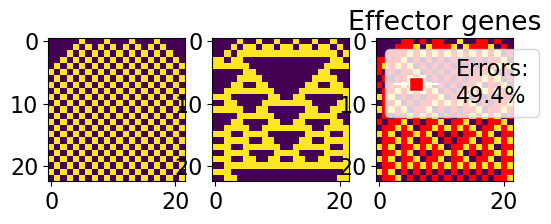

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


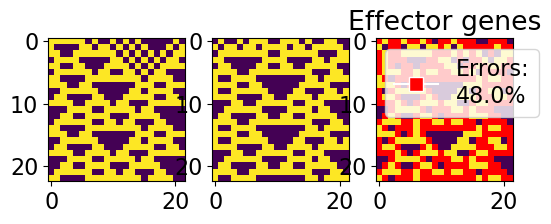

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


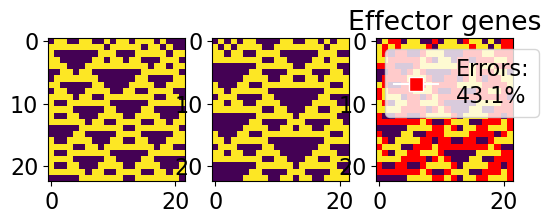

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


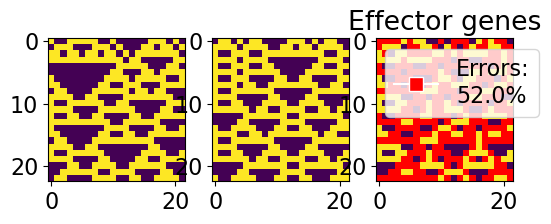

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


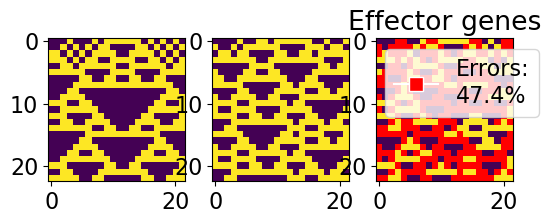

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


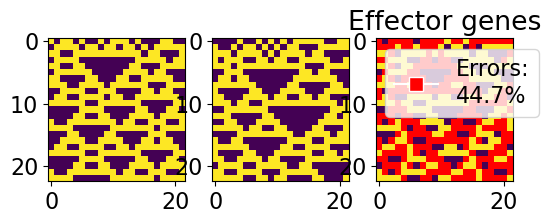

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


122


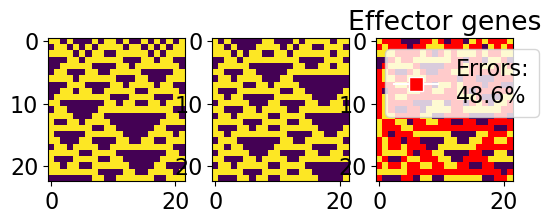

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


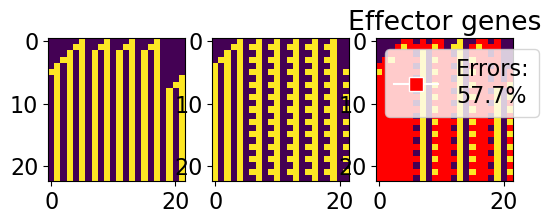

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


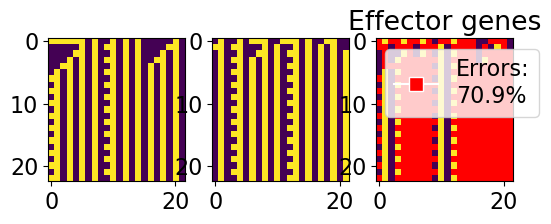

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


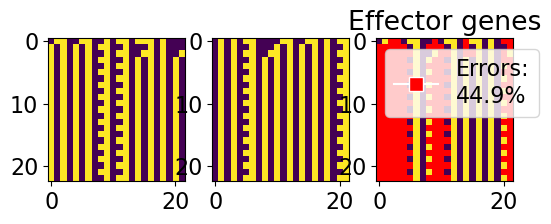

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


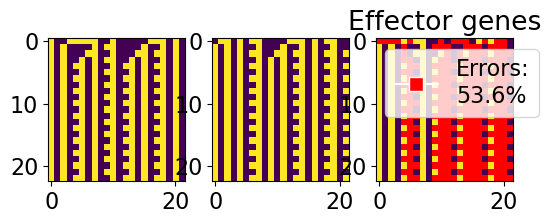

70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


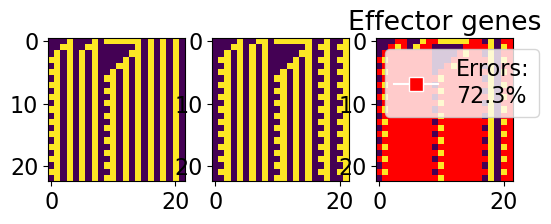

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


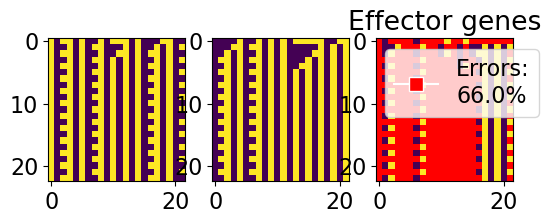

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


70


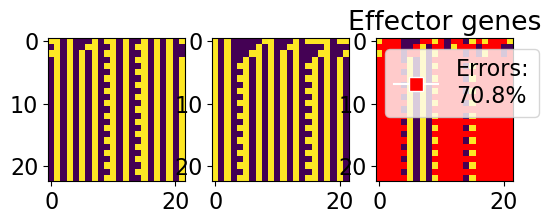

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


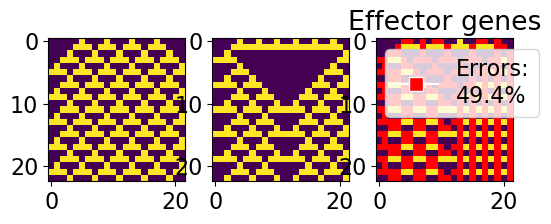

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


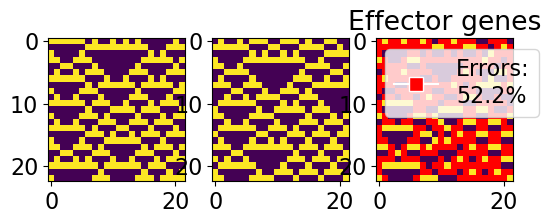

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


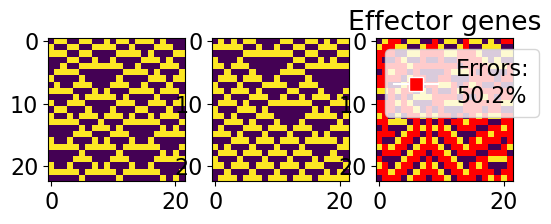

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


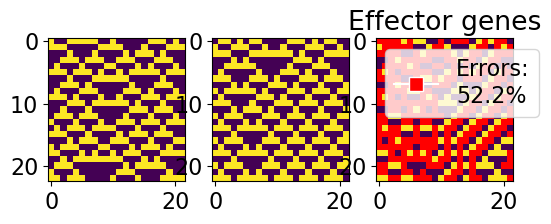

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


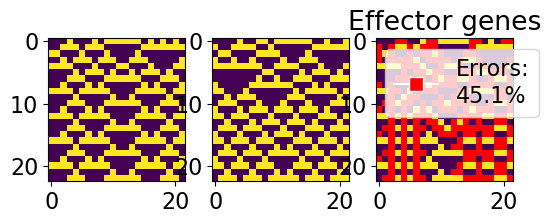

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


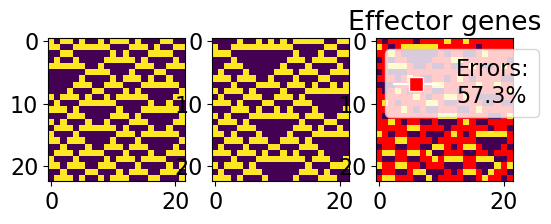

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


54


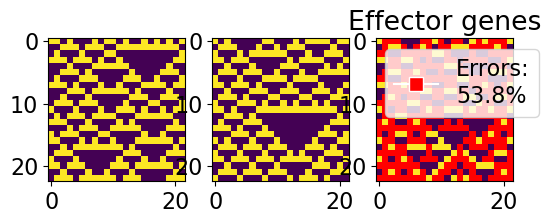

94


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


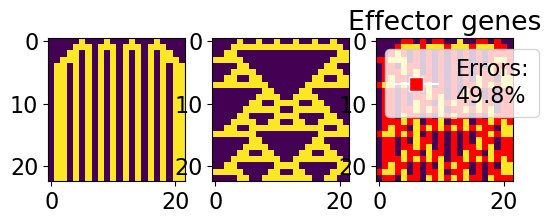

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


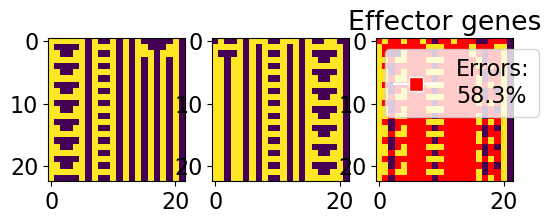

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


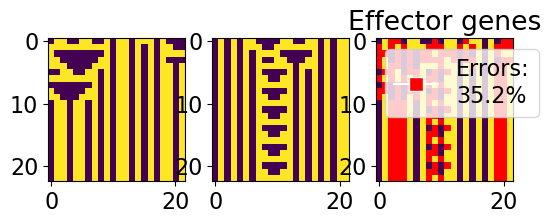

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


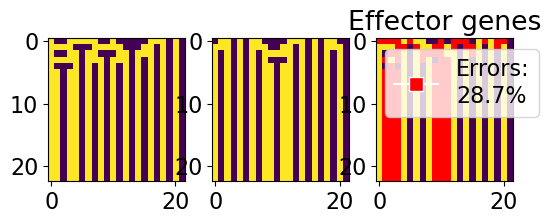

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


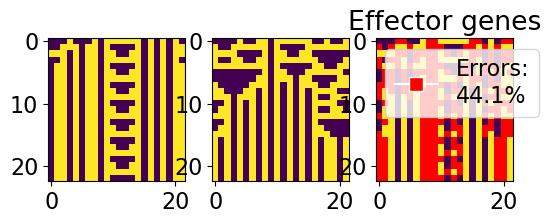

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


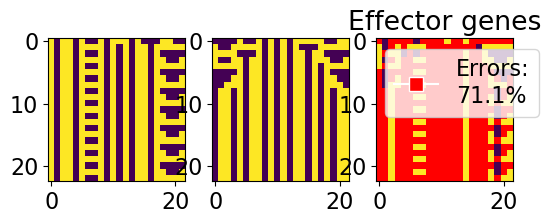

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


94


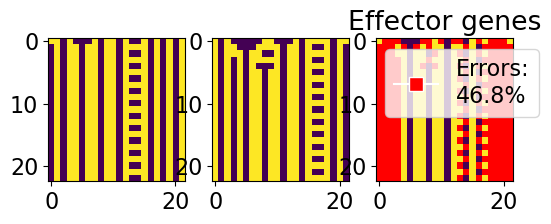

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


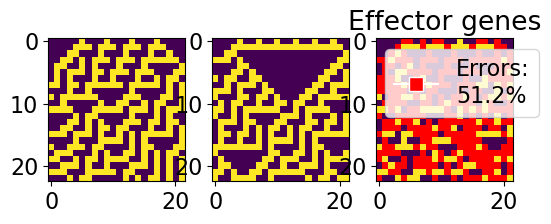

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


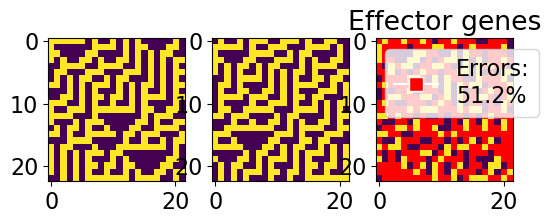

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


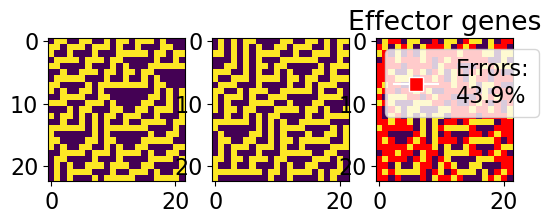

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


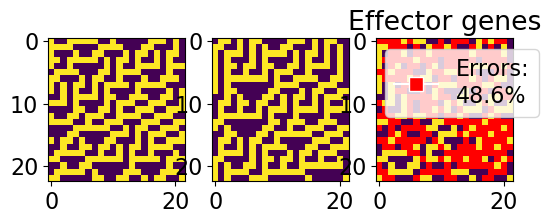

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


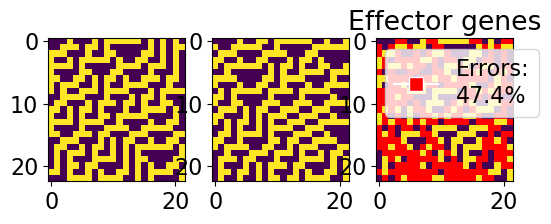

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


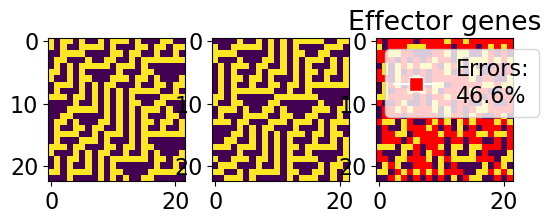

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30


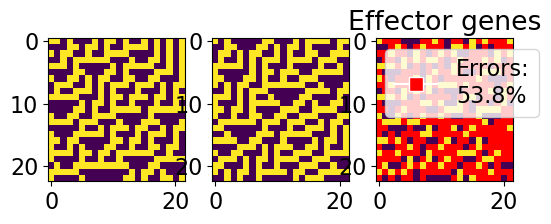

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


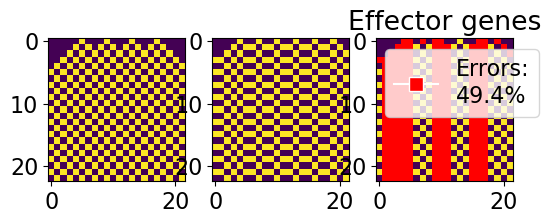

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


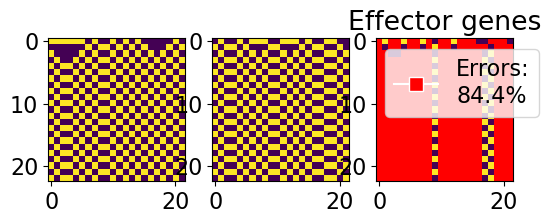

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


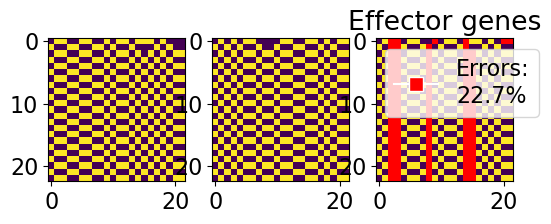

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


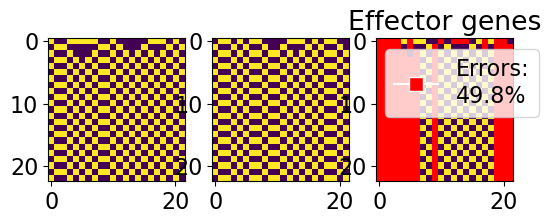

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


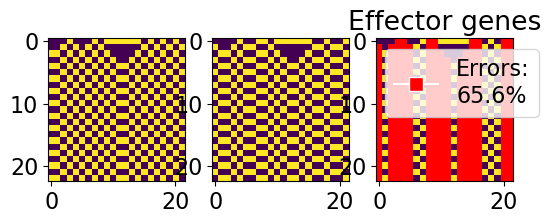

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


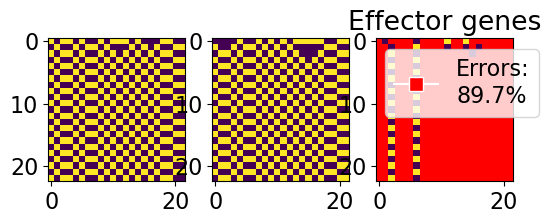

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50


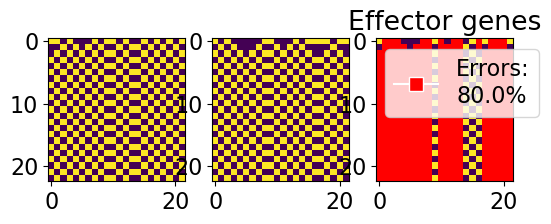

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


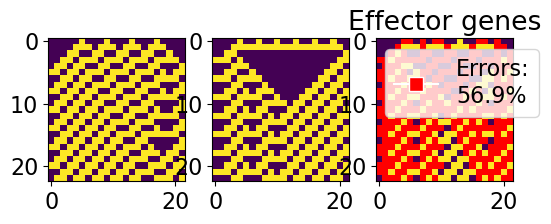

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


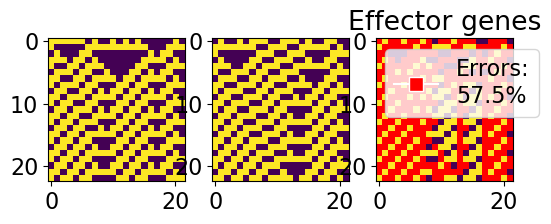

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


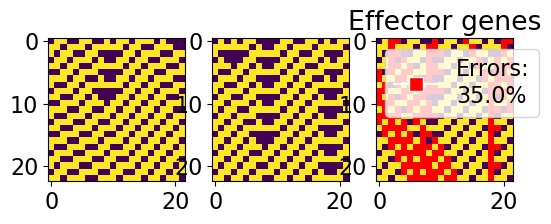

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


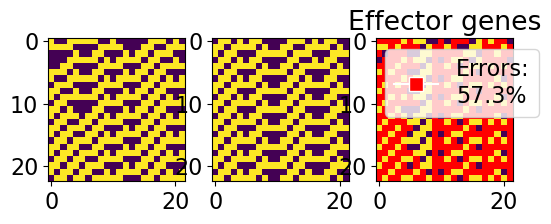

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


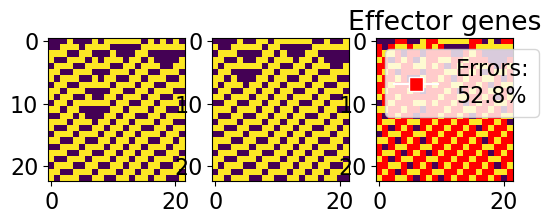

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


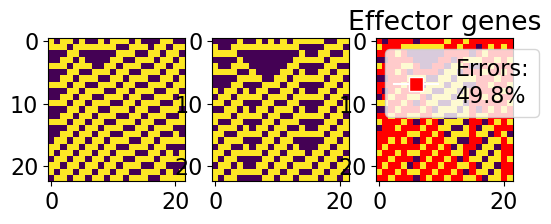

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


62


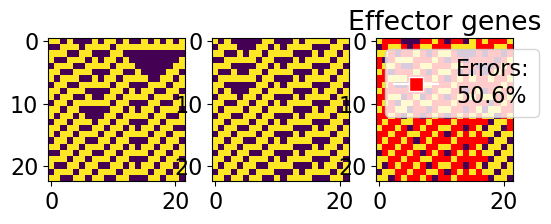

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


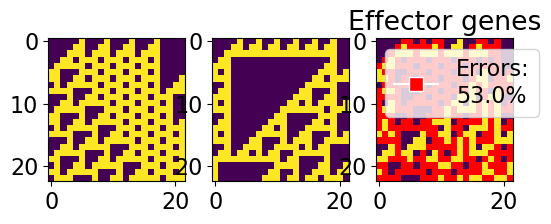

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


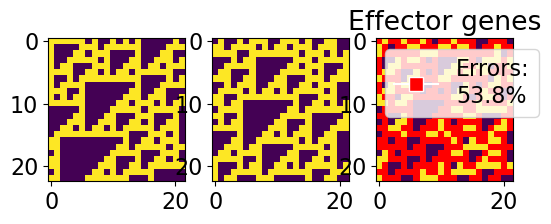

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


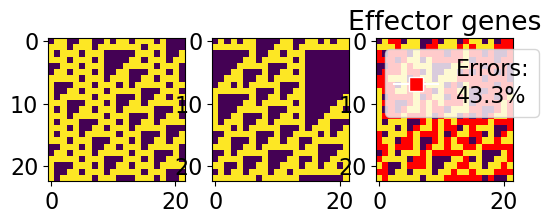

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


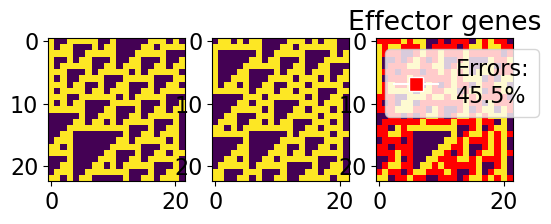

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


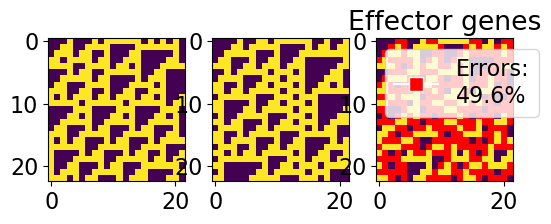

110


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


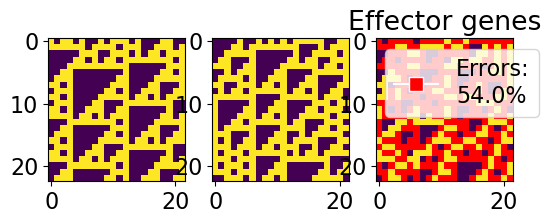

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


110


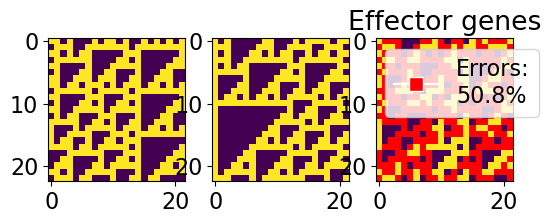

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


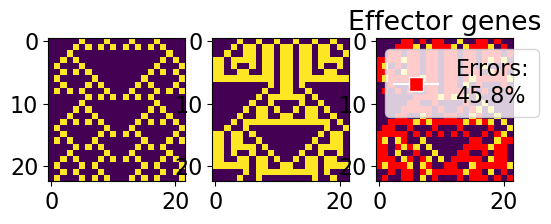

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


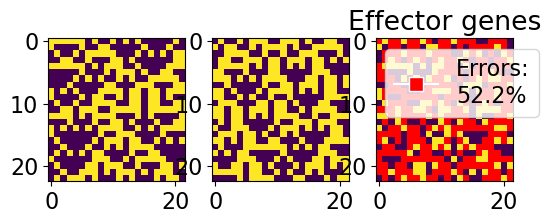

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


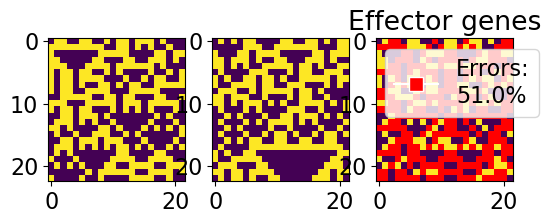

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


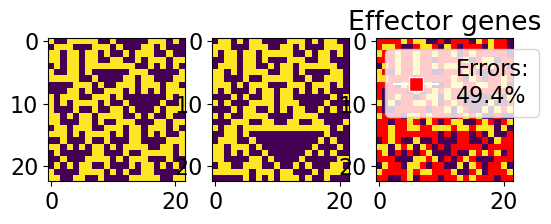

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


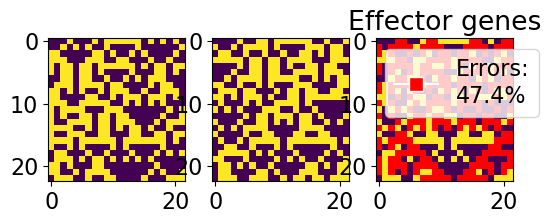

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


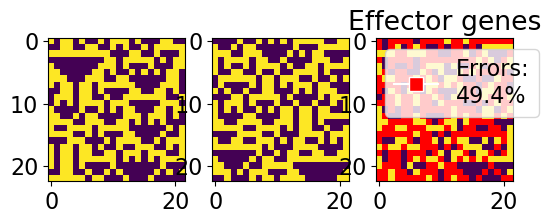

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90


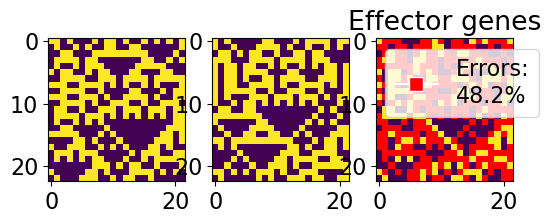

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


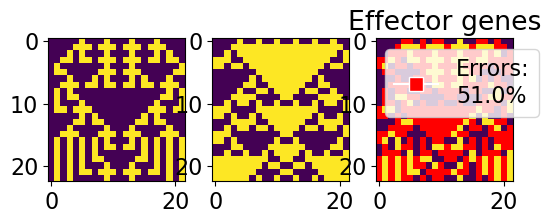

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


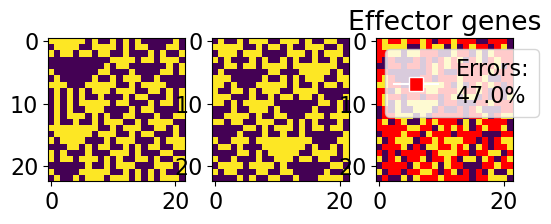

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


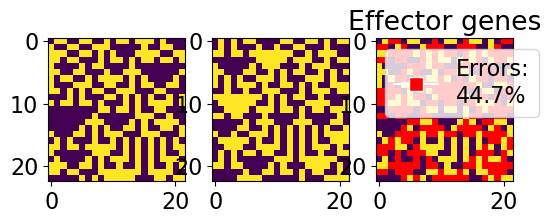

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


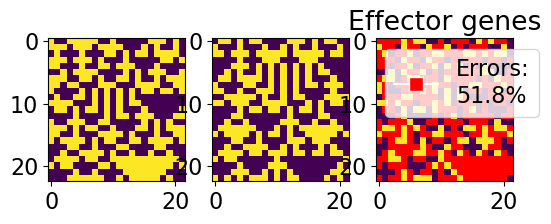

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


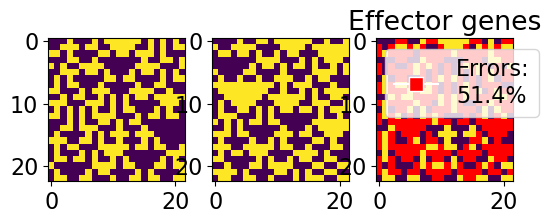

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


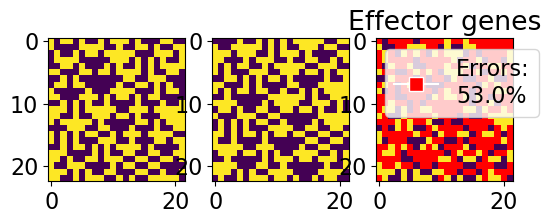

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150


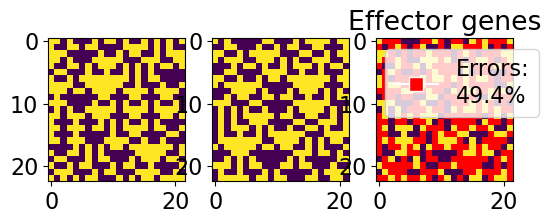

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


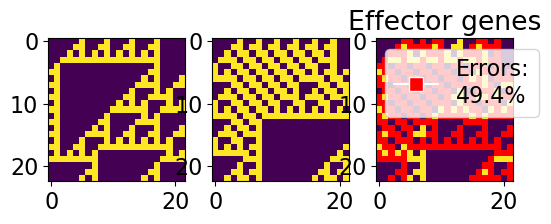

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


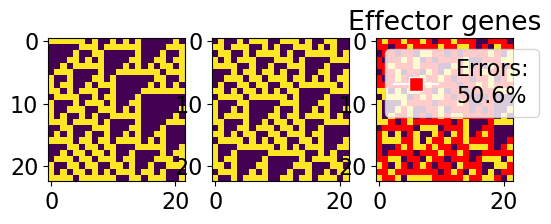

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


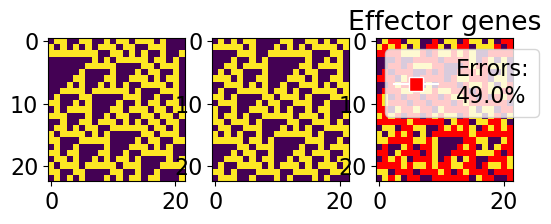

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


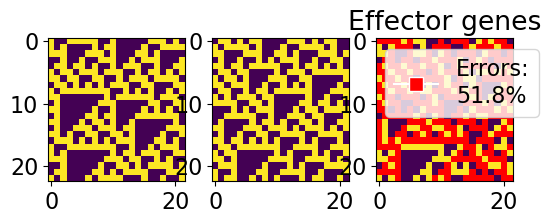

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


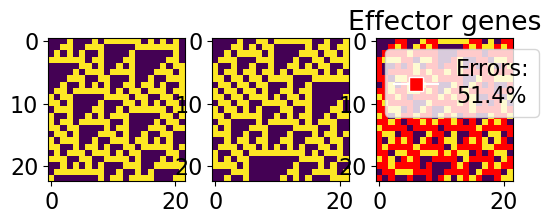

102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


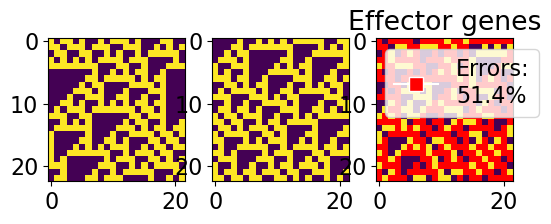

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102


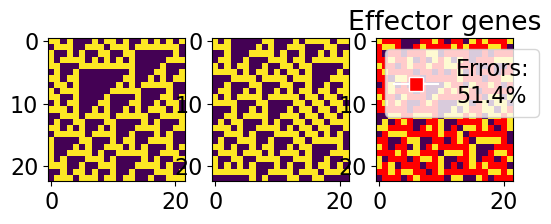

In [2]:
#Parameters
pop_size = 1000
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1

rule = 90
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
seed_ints = [69904,149796] #69904 #1024 #69904,149796,
#4147842,1238860,2481300

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
#rules=[38, 134,58, 84, 114, 162, 186, 242, 250]#np.array([22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102])
#rules = [0, 2, 4, 6, 8, 10, 12, 16, 20, 24, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 56, 64, 66, 68, 72, 74, 76, 78, 80, 88, 96, 98, 100, 104, 106, 108, 112, 116, 120, 128, 130, 132, 134, 136, 138, 140, 144, 148, 152, 160, 164, 166, 168, 170, 172, 174, 176, 178, 180, 184, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 216, 220, 224, 226, 228, 232, 234, 236, 238, 240, 244, 246, 248, 252, 254]
#rules=[237]
rules = [22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

ones=[]
twos=[]
for rule in rules:
    for seed in seed_intss:
        targets1, phenos, fitnesses1 = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed[0],seed[0])
        targets2, phenos, fitnesses2 = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed[1],seed[1])
        ones.append(fitnesses1.max())
        twos.append(fitnesses2.max())
        print(rule)
        fig, axs = plt.subplots(ncols=3, figsize=(6, 4))
        #Plot best phenotype
        axs[0].imshow(targets1)
        #Plot target
        axs[1].imshow(targets2)
        #Plot difference
        helper.show_effectors(targets1, targets2, M=0, ax=axs[2])
        plt.show()

#pickle.dump(phenos, open("random_phenos.p", "wb" ) )
#phenos = pickle.load(open("random_phenos.p", "rb"))

In [7]:
def global_devel(seed, GRN):
    N = seed.shape[0]
    history = np.empty((N+1,N), dtype=seed.dtype)
    history[0] = seed
    for i in range(1,N+1):
        matmul = GRN.dot(history[i-1])
        history[i] = 1 / (1 + np.exp(-matmul)) #same as helper.sigmoid(matmul, 1, 0), njit problems with different input shape
    return history

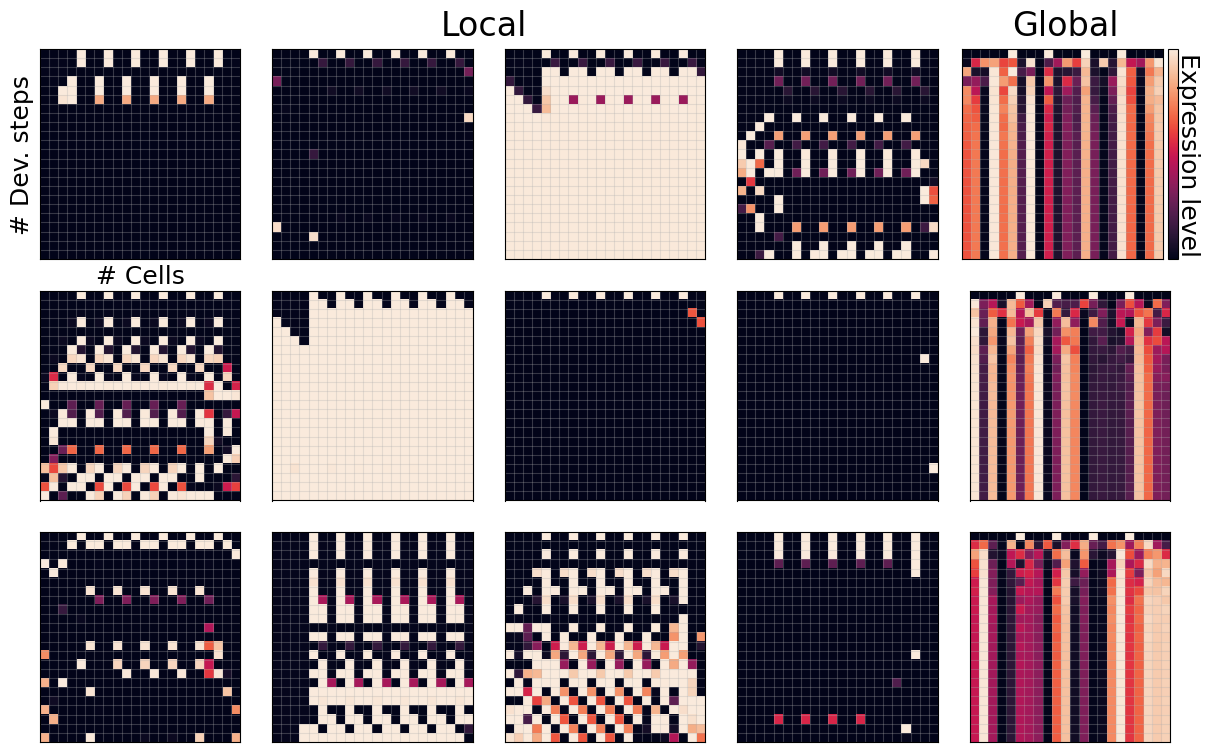

In [8]:
ncols = 5
nrows = 3
scale = 3
fig, axs = plt.subplots(figsize=(ncols * scale, nrows * scale), ncols=ncols, nrows=nrows)

l = 0
for i, ax in enumerate(axs.flatten()):

    if i % ncols == ncols - 1:
        GRN = np.random.randn(22, 22)
        pheno = global_devel(np.array(helper.seedID2string(seed_ints[0], num_cells)).astype(np.float64), GRN)
        im = helper.imshow_ca(pheno, ax=ax)
        if i == ncols - 1:
            #ax.set_title("Global")
            ax.text(5, -2, 'Global', fontsize=24)
            # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax, ticks=[])
            #cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
            cbar.set_label("Expression level", rotation=270, labelpad=16, fontsize=18)
    elif i == 0:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1
        ax.set_xlabel("# Cells", fontsize=18)
        #ax.xaxis.set_label_position("top")
        ax.set_ylabel("# Dev. steps", fontsize=18)
        #ax.set_title("Local")
    elif i == 1:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1
        ax.text(18, -2, 'Local', fontsize=24)
    else:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1

plt.subplots_adjust(wspace=0, hspace=0.15)
#plt.tight_layout()
#plt.savefig("figs/random_pheno_distribution.png")
plt.show()

In [26]:
np.arange(0,3)

array([0, 1, 2])

In [15]:
#rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]
rules=[30, 50, 54, 70, 22, 126, 154, 18, 122,94,62,110,90,150,102]

#num_rand = 10
#rules = np.random.choice(np.arange(0,256),num_rand,replace=False)

fits=[]
for rule in rules:
    targets, calc_phenos, calc_fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_ints[0],seed_ints[0])
    fits.append(calc_fitnesses)

#pickle.dump(fits, open("random_fits_all256.p", "wb" ) )
#fits = pickle.load(open("random_fits.p", "rb"))

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

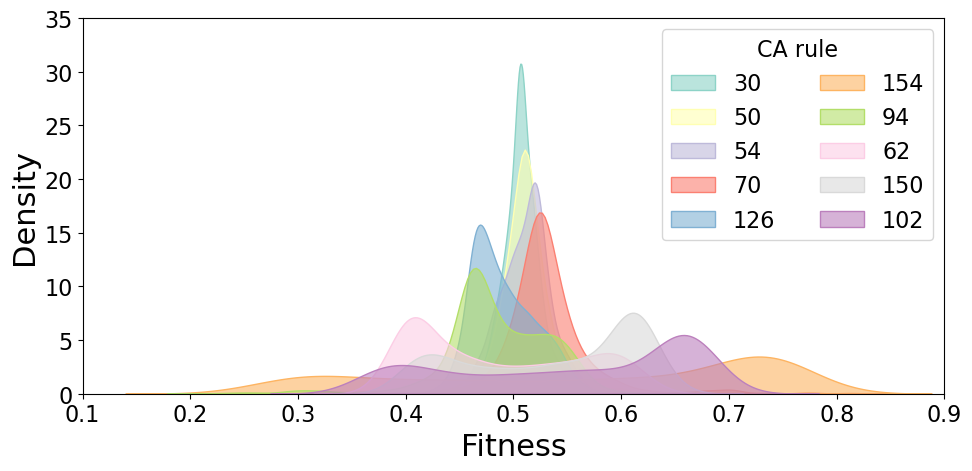

In [16]:
rules=[30, 50, 54, 70, 22, 126, 154, 18, 122,94,62,110,90,150,102]
#rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]


rules_plot = [30,50,54,70,126,154,94,62,150,102]

colors = sns.color_palette("Set3", len(rules_plot))

plt.figure(figsize=(10, 5)) 

c=0
for idx, data in enumerate(fits):
    if rules[idx] in rules_plot:
        sns.kdeplot(data, fill=True,label=rules[idx],color=colors[c],alpha=0.6)
        c+=1
    
#plt.legend(title="CA rule",ncol=2,loc="upper left")
handles, labels = plt.gca().get_legend_handles_labels()

plt.legend(handles, labels,title="CA rule",ncol=2,loc="upper right")

plt.xlabel("Fitness",fontsize=22)
plt.ylabel("Density",fontsize=22)
plt.xlim(0.1,0.9)
plt.ylim(0,35)
plt.tight_layout()
plt.show()
#plt.savefig("figs/random_grn_fitness.png")

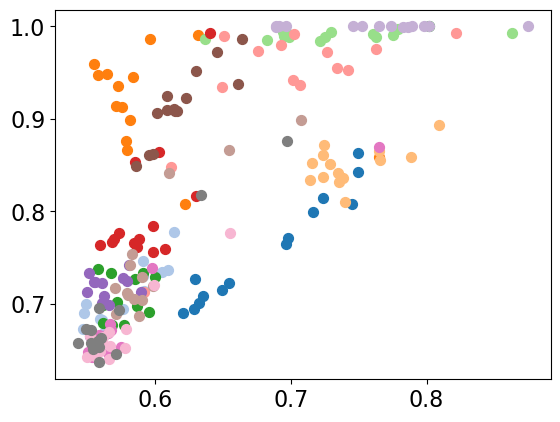

In [93]:
root1="~/scratch/detailed_save/"
root2="~/scratch/non_detailed_save/"
root3="~/scratch/non_detailed_save/extra_inputs/"
season_len = 100_000
seed_ints = [69904,149796] #[4147842,1238860]###
seed_intss = [[69904,149796],[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric = "maxfits"
num_reps = 15
id_start = 0

pop_size = 1000
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

colors = sns.color_palette("tab20", len(rules))

c=0
all_avs=[]
all_rand=[]
for rule in rules:
     avs=[]
     rand=[]
     for si in seed_intss:
          for s in si:
               targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, s,s)
               if s == 69904 or s == 149796:
                    root = root1
               elif s== 4147842 or s == 1238860:
                    root = root2
               else:
                    root = root3
               maxs=[np.loadtxt(os.path.expanduser(root+f"static/stats_{season_len}_{rule}_{s}_{i+1+id_start}_{metric}.txt")) for i in range(num_reps)]
               avs.append(np.array(maxs)[:,-1].mean())
               all_avs.append(np.array(maxs)[:,-1].mean())
               rand.append(fitnesses.max())
               all_rand.append(fitnesses.max())
    #print(avs)
     plt.scatter(rand, avs, color=colors[c],label=rule,s=50)
     #plt.hist(avs,color=colors[c],bins=15)
     c+=1
#plt.legend()
#plt.xlabel("average random")
#plt.ylabel("evolved max")
plt.show()

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

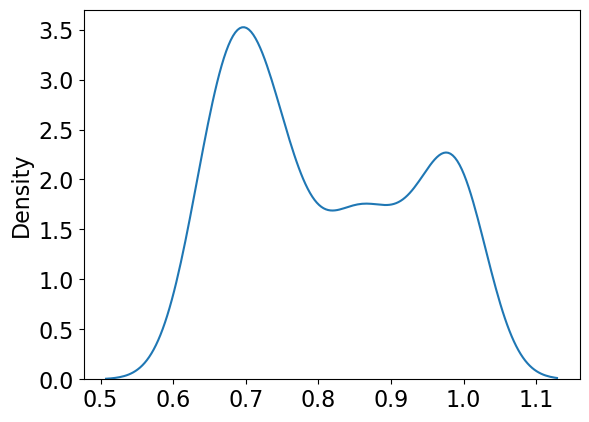

In [92]:
#plt.hist(all_avs,bins=15)
sns.kdeplot(all_avs)

0.703305359068994 1.1689198722012828e-32


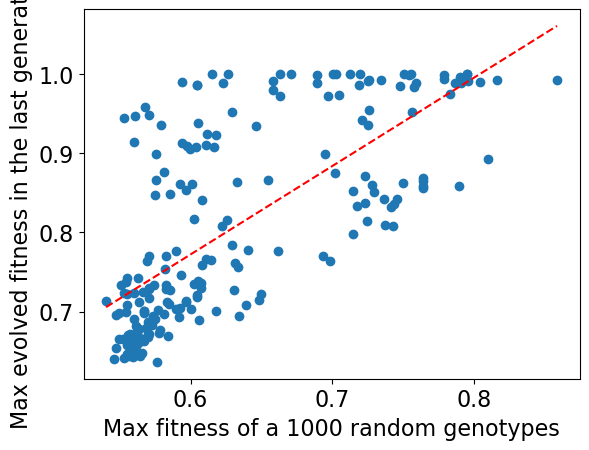

In [83]:
from scipy.stats import pearsonr, linregress
plt.scatter(all_rand, all_avs)
x=all_rand
y=all_avs
slope, intercept, r_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(min(x), max(x), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, color='red', linestyle='--', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.ylabel("Max evolved fitness in the last generation")
plt.xlabel("Max fitness of a 1000 random genotypes")
print(r_value,p_value)

In [17]:
root="~/scratch/detailed_save/"
season_len = 100_000
seed_ints = [69904,149796] #[4147842,1238860]###
seed_intss = [[69904,149796]]#,[4147842,1238860],[1677032,1410667],[2607162,1754028],[286634,159689],[2961036,153075],[3430997,2634107]]
metric = "maxfits"
num_reps = 15
id_start = 0

pop_size = 1000
grn_size = 22
num_cells = 22
dev_steps = 22
geneid = 1

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
#rules=[22, 126, 154, 18, 122, 70,54,94,30,50,62,110,90,150,102]

avs=[]
rand=[]
for si in seed_intss:
    for rule in rules_plot:
        targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, s,s)
        maxs=[np.loadtxt(os.path.expanduser(root+f"static/stats_{season_len}_{rule}_{seed_ints[0]}_{i+1+id_start}_{metric}.txt")) for i in range(num_reps)]
        avs.append(np.array(maxs)[:,-1].mean())
        rand.append(fitnesses.mean())

/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/users/c/p/cpetak/miniconda3/envs/ca_grn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as

0.7249555156312295 0
1.0 1
0.9926859047837574 2
0.9838693971295679 3
0.7458108206479842 4
0.8588209402827534 5
0.9893961674112448 6
0.9726457535432842 7
0.7768998846214848 8
0.8757776187680605 9


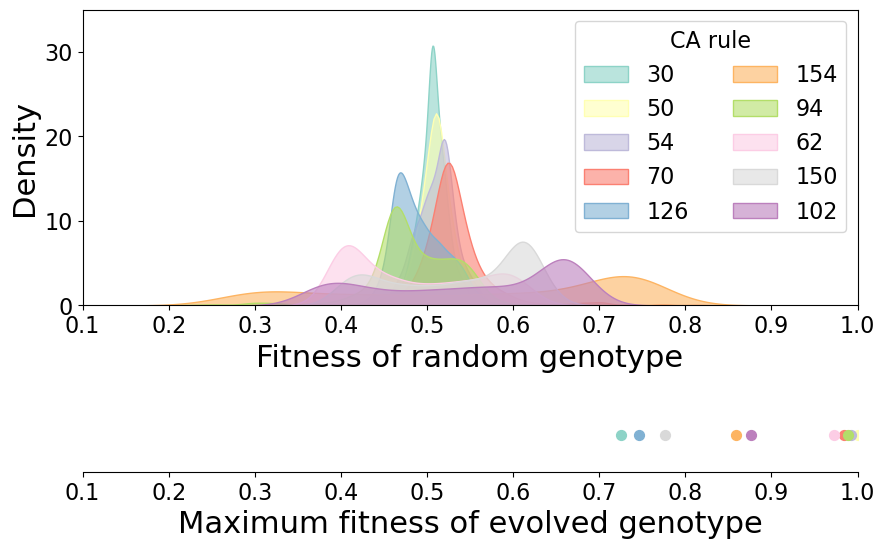

In [18]:
fig, (ax_kde, ax_dots) = plt.subplots(
    2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(10, 6), sharex=False
)
c=0
for idx, data in enumerate(fits):
    if rules[idx] in rules_plot:
        sns.kdeplot(data, fill=True,label=rules[idx],color=colors[c],alpha=0.6,ax=ax_kde)
        ax_dots.scatter(avs[c], 1, color=colors[c], s=50, zorder=3)  # Adjust `s` for dot size
        print(avs[c],c)
        c+=1

ax_kde.legend(title="CA rule", ncol=2,loc="upper right")

ax_kde.set_xlabel("Fitness of random genotype",fontsize=22)
ax_kde.set_ylabel("Density",fontsize=22)
ax_kde.set_xlim(0.1,1)
ax_kde.set_ylim(0,35)

# Format the dots subplot
ax_dots.set_xlabel("Maximum fitness of evolved genotype",fontsize=22)
ax_dots.set_xlim(0.1,1)
ax_dots.set_ylim(0, 2)  # Keep dots close to the x-axis
#ax_dots.axis('off')  # Remove axes for a cleaner look
ax_dots.spines['top'].set_visible(False)  # Hide the top spine
ax_dots.spines['right'].set_visible(False)  # Hide the right spine
ax_dots.spines['left'].set_visible(False)  # Hide the left spine
ax_dots.yaxis.set_visible(False) 

ax_kde.xaxis.set_tick_params(labelbottom=True)  # Ensure no labels are above the plot

# Adjust the layout to minimize spacing
plt.subplots_adjust(hspace=0.5)

plt.show()

0.7249555156312295 0
1.0 1
0.9926859047837574 2
0.9838693971295679 3
0.7458108206479842 4
0.8588209402827534 5
0.9893961674112448 6
0.9726457535432842 7
0.7768998846214848 8
0.8757776187680605 9


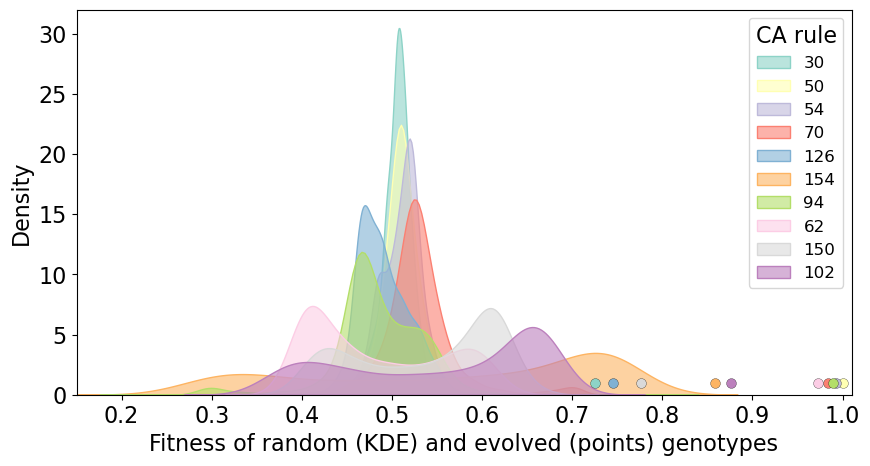

In [118]:
plt.figure(figsize=(10, 5)) 

c=0
for idx, data in enumerate(fits):
    if rules[idx] in rules_plot:
        sns.kdeplot(data, fill=True,label=rules[idx],color=colors[c],alpha=0.6)
        plt.scatter(avs[c], 1, color=colors[c], s=50, zorder=3,edgecolors="black", linewidths=0.2)  # Adjust `s` for dot size
        print(avs[c],c)
        c+=1

plt.legend(title="CA rule", ncol=1,loc="upper right",fontsize = 12)
plt.xlim(0.15,1.01)
plt.xlabel("Fitness of random (KDE) and evolved (points) genotypes")
plt.show()

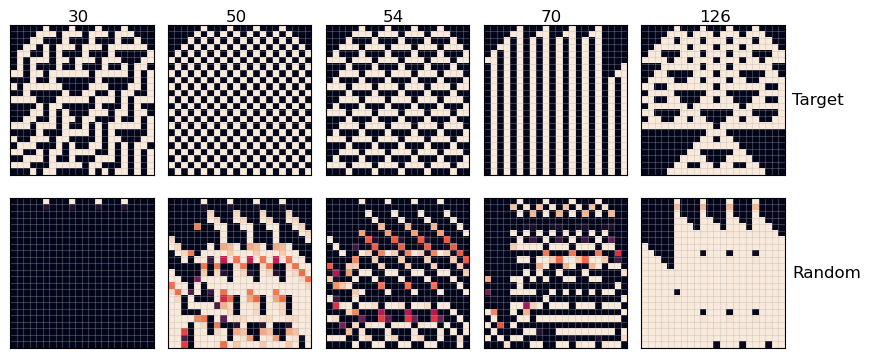

In [53]:
fig, axs = plt.subplots(
    2, 5, figsize=(10, 6), sharex=True, sharey=True
)
rules_plot = [30,50,54,70,126,154,94,62,150,102]
axss=axs.flatten()

np.random.seed(42)
pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)

c=0
for i, rule in enumerate(rules_plot):
    targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_ints[0],seed_ints[0])
    if c<5: #i%2==0:
        helper.imshow_ca(targets, ax=axss[i])
        axss[i].text(0.4, 1.05, rule, transform=axss[i].transAxes, va='center', ha='left', fontsize=12)
        if c == 4:
            axss[i].text(1.05, 0.5, "Target", transform=axss[i].transAxes, va='center', ha='left', fontsize=12)

    else:
        helper.imshow_ca(phenos[i+110,:,:], ax=axss[i])
        if c == 9:
            axss[i].text(1.05, 0.5, "Random", transform=axss[i].transAxes, va='center', ha='left', fontsize=12)

    c+=1

plt.subplots_adjust(hspace=-0.4, wspace=0.1)  # Adjust hspace (vertical) and wspace (horizontal)
plt.show()

In [107]:
worst= -num_cells*dev_steps
start_pattern = np.array(helper.seedID2string(seed_int, num_cells)).astype(np.float64)
fits=[]
for rule in rules:
    target = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    phenos = []
    for p in range(pop_size):
        GRN = np.random.randn(grn_size, grn_size) #4 random GRNs
        phenos.append(global_devel(start_pattern, GRN))
    prefitnesses = helper.fitness_function_ca(phenos, target)
    fitnesses=1-(prefitnesses/worst) #0-1 scaling
    fits.append(fitnesses)


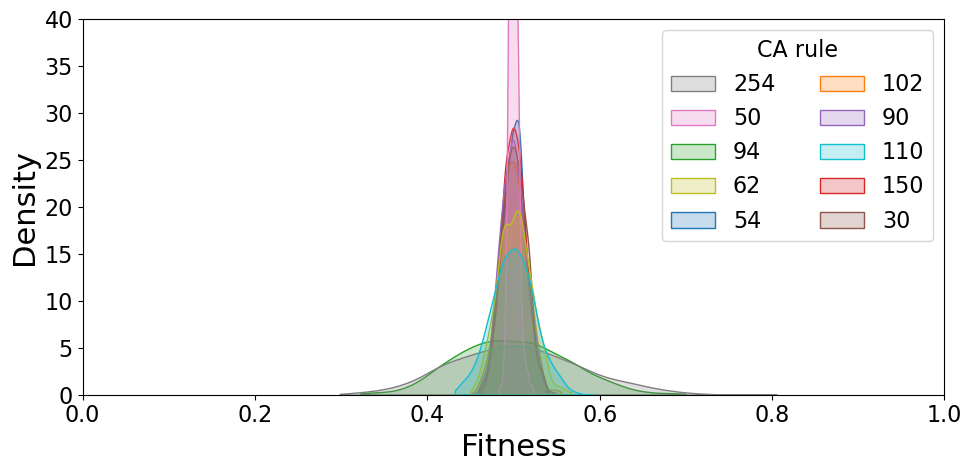

In [108]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rules=[54,102,94,150,90,30,50,254,62,110]
rule_order=[254,50,94,62,54,102,90,110,150,30]
order=[]
for i in rule_order:
    j=np.where(np.array(rules) == i)[0][0]
    order.append(j)

plt.figure(figsize=(10, 5)) 
for i,f in enumerate(fits):
    sns.kdeplot(f,fill=True,label=rules[i],clip=(min(f), max(f)))

#plt.legend(title="CA rule",ncol=2,loc="upper left")
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder handles and labels
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

plt.legend(handles, labels,title="CA rule",ncol=2,loc="upper right")

plt.xlabel("Fitness",fontsize=22)
plt.ylabel("Density",fontsize=22)
plt.xlim(0,1)
plt.ylim(0,40)
plt.tight_layout()
plt.show()
#plt.savefig("figs/random_grn_fitness.png")

#### Where it is in the fitness landscape?

In [28]:
#Parameters
pop_size = 1000
grn_size = 10
num_cells = 22
dev_steps = 22
geneid = 1


In [33]:
seed_int = 1024 #1024 #69904,149796,4147842,1238860,2481300
rule = 30

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)

In [34]:
selection_prop = 0.1
mut_rate = 0.1
mut_size = 0.5

selection_size=int(pop_size*selection_prop) #100 are selected to reproduce
num_child = 100#int(pop_size / selection_size) - 1 #9 kids for each selected
tot_children = num_child * selection_size #900 kids in total
num_genes_mutate = int((grn_size + 2) * grn_size * tot_children * mut_rate) #mut_rate percent of all genes across all kids mutated, so 10%
mutations = np.random.randn(num_genes_mutate) * mut_size #generate num_genes_mutate mutations, scaled by mut_size

children = np.tile(pop, (num_child, 1, 1))

x, y, z = children.shape
#children is a 3D object, 2d genome for N individuals, find num_genes_mutate points in this object to mutate
xs = np.random.choice(x, size=num_genes_mutate) 
ys = np.random.choice(y, size=num_genes_mutate)
zs = np.random.choice(z, size=num_genes_mutate)
children[xs, ys, zs] = children[xs, ys, zs] + mutations

reshaped=np.reshape(children, (num_child, pop_size, grn_size+2, grn_size))
reshaped=np.transpose(reshaped, [1, 0, 2, 3])
reshaped.shape
#reshaped[0] is a list of 9 elements, all kids of 1 parent

(1000, 100, 12, 10)

In [35]:
_, _, pop_fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)
pos_perc=[]
for idx, c in enumerate(reshaped):
    _, _, kid_fitnesses = helper.get_pop_TPF(c, num_child, num_cells, grn_size, dev_steps, geneid, rule, seed_int)
    pos_perc.append(len(np.where(kid_fitnesses > pop_fitnesses[idx])[0])/len(kid_fitnesses))

Text(0.5, 1.0, 'Rule: 30, seed: 1024')

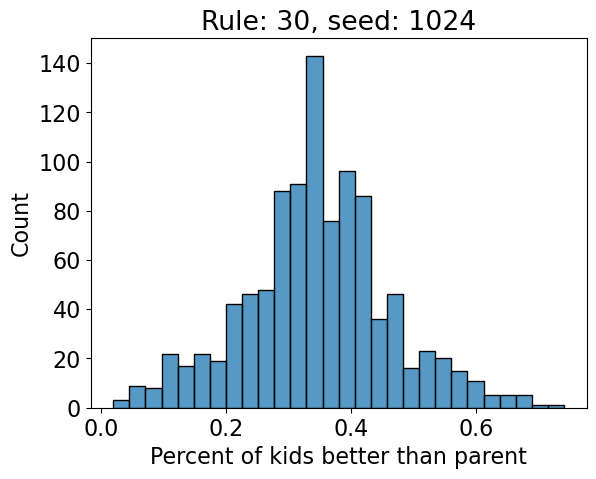

In [36]:
#sns.kdeplot(pop_fitnesses)
sns.histplot(pos_perc)
plt.xlabel("Percent of kids better than parent")
plt.title(f'Rule: {rule}, seed: {seed_int}')

In [ ]:
#SUPP code
plt.scatter(ones, twos)
for i, label in enumerate(rules):
    plt.text(ones[i], twos[i], label, fontsize=9, ha='right')
plt.xlim(0.45, 0.6)
plt.ylim(0.45, 0.6)
plt.plot([0.45, 0.6], [0.45, 0.6], color='red', linestyle='--')
plt.xlabel("Average fitness of random GRN in env 1", fontsize = 12)
plt.ylabel("Average fitness of random GRN in env 2", fontsize = 12)

plt.scatter(ones, twos)
for i, label in enumerate(rules):
    plt.text(ones[i], twos[i], label, fontsize=9, ha='right')
plt.xlim(0.5, 0.9)
plt.ylim(0.5, 0.9)
plt.plot([0.5, 0.9], [0.5, 0.9], color='red', linestyle='--')
plt.xlabel("Max (of 1000) fitness of random GRNs in env 1", fontsize = 12)
plt.ylabel("Max (of 1000) fitness of random GRNs in env 2", fontsize = 12)